In [3]:
import os, sys
import os, sys
project_dir = os.getcwd()
if project_dir not in sys.path:
    sys.path.append(project_dir)

import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from spectral.algorithms import spectral_angles
from dataset import DermaDataset

In [8]:
dataset_root_dir = "/home/abian/Data/Dataset/IUMA/DermaDatabase/dataCubes/"
train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(dataset_root_dir, x), train_dir))

dataset = DermaDataset(dataset_dir)
x, y = dataset.get()

# Data Preprocessing

## Calibration 

$\begin{align}
    C_i = 100 * \frac{R_i - D_r}{W_r - D_r}
\end{align}$

where $C_i$ is the calibrated image, $R_i$ note raw image and the $W_r$ and $D_r$ represents the white and dark reference image, respectively.


In [9]:
# W_r y D_r es una imagen
def calibrate(img, w_r, d_r):
    if not(w_r.shape == d_r.shape == img.shape):
        assert('Dimensionality error')
    
    return 100  * (img - d_r) / (w_r - d_r)

# Normalize data
$\begin{align}
    P'_i = \frac{P_i - P_{min}}{P_{max} - P_{min}}
\end{align}$

where $P'_i$ is the normalized pixel value, $P_i$ the reflectance of the pixel, $P_{min}$ and $P_{max}$ is the minimum and maximum reflectance value, respectively.

In [10]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Sampling Interval Analysis

Selected equidistant band ...

$\begin{align}
    Sampling Interval (nm) = \frac{\lambda_{max} - \lambda_{min}}{N_{\lambda}}
\end{align}$

where $\lambda_{max} - \lambda_{min}$ is the difference between the mamum and minimum wavelength and $N_{\lambda}$ is the number of band captured by the sensor.

In [11]:
def sampling_interval(lambda_min, lambda_max, n_spectral_bands):
    '''
        Param:
        -----
            lambda_min (int): minimum wavelenght
            lambda_max (int): maximum wavelenght
            n_spectral_bands (int): number of spectral bands captured by the sensor
    '''
    return (lambda_max - lambda_min) / n_spectral_bands

# Dataset reduction

**Spectral Angle Mapper**

$\alpha = cos^{-1}\left ( \frac{\sum_{i = 1}^{nb} t_{i} r_{i}}{(\sum_{i = 1}^{nb} t_{i}^2)^{\frac{1}{2}} (\sum_{i = 1}^{nb} r_{i}^2)^{\frac{1}{2}}} \right )$

where

* $\alpha$ = spectral angle between the standard and the spectral curve of the pixel
* $nb$ = number of spectral channels
* $t$ = vector of spectral response of the standard
* $r$ = the spectral response vector of the analyzed pixel

In [116]:
from spectral.algorithms import spectral_angles
from sklearn.cluster import KMeans

def spectral_angles_pixel(x, ref):
    '''
        For pixel input, the original function is prepare for image
    '''
    return spectral_angles(x[np.newaxis,:], ref)[0]

def get_most_relevant_samples(x, centroid, n_samples_per_centroid=10):
    '''
        Paper: Most Relevant Spectral Bands Identification for Brain
        Cancer Detection Using Hyperspectral Imaging    
    '''
    if len(x.shape) != 2:
        assert 'X shape error!'
    
    output = None
    result = spectral_angles_pixel(x, centroid)
    for i in range(len(centroid)):       
        ind = np.argpartition(result[i], -n_samples_per_centroid)[-n_samples_per_centroid:]
        if i == 0:
            output = x[ind]
        else:
            output = np.concatenate([output, x[ind]], axis=0)

    return output

def get_most_relevant_samples_idx(x, centroid, n_samples_per_centroid=10):
    '''
        Paper: Most Relevant Spectral Bands Identification for Brain
        Cancer Detection Using Hyperspectral Imaging    
    '''
    if len(x.shape) != 2:
        assert 'X shape error!'
    
    output = np.array([], dtype=np.uint)
    result = spectral_angles_pixel(x, centroid)
    print(result.shape)
    for i in range(len(centroid)):       
        ind = np.argpartition(result[:, i], -n_samples_per_centroid)[-n_samples_per_centroid:].astype(np.uint)
        output = np.concatenate((output, ind))

    return output

def dataset_reduction(x, y, n_centroid_per_class=100, random_state=123):
    class_label = np.unique(y)
    final_x = None
    final_y = None
    final_idx = np.array([])
    for i in range(len(class_label)):
        print('CLass: {}'.format(i))
        idx = np.where(y==class_label[i])
        _x = x[idx]
        # print(_x)
        if len(idx[0]) > 1000:
            kmeans = KMeans(n_clusters=n_centroid_per_class, random_state=random_state).fit(_x)
            centroid = kmeans.cluster_centers_
            # _x = get_most_relevant_samples_idx(_x, centroid)
            most_relevant_samples_idx = get_most_relevant_samples_idx(_x, centroid)
            # print(idx[0][most_relevant_samples_idx])
            final_idx = np.concatenate((final_idx, idx[0][most_relevant_samples_idx]))
            # test = np.concatenate([test, get_most_relevant_samples_idx(_x, centroid)]) 
            # print(test)

    #     if i == 0:
    #         final_x = _x
    #         final_y = np.full((_x.shape[0],), class_label[i])
    #     else:
    #         final_x = np.concatenate([final_x, _x], axis=0)
    #         final_y = np.concatenate([final_y, np.full((_x.shape[0],), class_label[i])], axis=0)
    
    return final_idx
    # return final_x, final_y

In [162]:
class_label = np.unique(y)
for i in range(len(class_label)):
    idx = np.where(y==class_label[i])
    _x = x[idx]
    kmeans = KMeans(n_clusters=100, random_state=123).fit(_x)
    centroid = kmeans.cluster_centers_
    labels = kmeans.labels_
    # result = spectral_angles_pixel(x, centroid)
    # output = np.array([], dtype=np.uint)
    # for i in range(len(centroid)):       
    #     ind = np.argpartition(result[:, i], -10)[-10:].astype(np.uint)
    #     output = np.concatenate((output, ind))
    # break

In [165]:
labels.shape

(7295,)

In [158]:
np.unique(output)

array([ 111,  247,  264,  265,  284,  437,  438,  461,  462,  558,  607,
        621,  628,  651, 6560, 6561, 6694, 6695, 6699, 6709, 6710, 6711,
       6714, 6715, 6724, 6725, 6726], dtype=uint64)

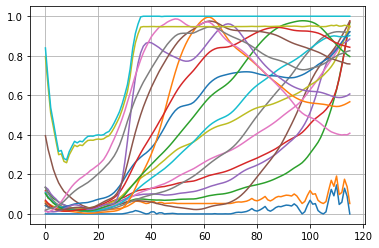

In [148]:
import matplotlib.pyplot as plt

plt.figure()

for i in range(c.shape[0]):
    plt.plot(c[i])

plt.grid()

In [146]:
x.reshape(1, -1).shape

(1, 1234008)

In [141]:
print(output.shape)
print(np.unique(output).shape)

(1000,)
(27,)


In [130]:
a = np.array([])
for i in range(100):
    min_value = np.min(result[:, i])
    a = np.concatenate([a, np.argwhere(result[:, i] == min_value).reshape(-1)])

np.unique(a)


array([   56.,    58.,   758.,   763.,  2133.,  2170.,  2184.,  2285.,
        2323.,  2342.,  2349.,  2354.,  2381.,  2417.,  2426.,  2438.,
        2544.,  2556.,  2584.,  2588.,  2590.,  2621.,  2632.,  2666.,
        2686.,  2743.,  2745.,  2820.,  2825.,  3010.,  3015.,  3035.,
        4719.,  4810.,  5800.,  5885.,  5894.,  5950.,  5997.,  6024.,
        6038.,  6086.,  6174.,  6189.,  6252.,  6266.,  6295.,  6381.,
        6451.,  6502.,  6510.,  6735.,  6737.,  6754.,  6795.,  6858.,
        6882.,  6925.,  6941.,  6962.,  7021.,  7080.,  7351.,  8192.,
        8221.,  8229.,  8264.,  8271.,  8337.,  8819.,  8861.,  8913.,
        8962.,  8966.,  9003.,  9028.,  9337.,  9382.,  9387.,  9414.,
        9420.,  9476.,  9503.,  9517.,  9531.,  9549.,  9567.,  9572.,
        9573.,  9574.,  9589.,  9607.,  9609.,  9611.,  9624.,  9646.,
        9668., 10311., 10328., 10553.])

In [131]:
a.shape

(100,)

In [118]:
# x_red, y_red = dataset_reduction(x, y, n_centroid_per_class=100)
samples_idx = dataset_reduction(x, y, n_centroid_per_class=100)
samples_idx
print(np.unique(samples_idx))
# print(x_red.shape)
# print(y_red.shape)

CLass: 0
(3343, 100)
CLass: 1
(7295, 100)
[  25.   30.   35.   40.   45.   50.   55.   59.   60.   65.   95.   96.
  111.  247.  264.  265.  284.  437.  438.  461.  462.  537.  558.  581.
  607.  621.  628.  651. 2156. 2161. 2416. 2421. 2439. 2457. 2501. 2519.
 2520. 2536. 2537. 2597. 2614. 2616. 2626. 2627. 2628. 2637. 2638. 2639.
 2640. 2641. 3048. 3049. 3050. 3059. 3060. 3061. 3063. 3074. 3075. 6560.
 6561. 6575. 6694. 6695. 6699. 6709. 6710. 6711. 6714. 6715. 6722. 6724.
 6725. 6726.]


In [119]:
test = y[samples_idx.astype(np.uint)]
len(test[test==1])

1000

In [54]:
test = np.array([])
test.size

0

In [3]:
from imblearn.under_sampling.base import BaseUnderSampler
from spectral.algorithms import spectral_angles
from sklearn.cluster import KMeans

## Por ahora no usar!!! Está en pruebas!!

class HyperSpectralUnderSampler(BaseUnderSampler):
    ''' 
        Class to perform HyperSpectral data under-sampling.

        Under-sample the different class(es) by K-Mean unsupervised clustering approach. The K-Means clustering 
        is applied independently to each group of labeled pixels in order to obtain K clusters per group. In order 
        to reduce the original training dataset, such centroids are employed to identify the most representative pixels of
        each class by using the Spectral Angle [2] algorithm. For each cluster centroid, only the S most similar
        samples are selected.

        Parameters
        ----------
        n_clusters: int, default=100
            The number of centroids used in K-Mean clustering (K).
        
        samples_per_class: int, default=10
            The number of most similiar signals to select (S)

        {random_state}

        References
        ----------
          [1] Martinez, B., Leon, R., Fabelo, H., Ortega, S., Piñeiro, J. F., Szolna, A., ... & M Callico, G. (2019). Most
          relevant spectral bands identification for brain cancer detection using hyperspectral imaging.Sensors, 19(24), 5481.
          
          [2] Rashmi, S.; Addamani, S.; Ravikiran, A. Spectral Angle Mapper algorithm for remote sensing image classification. 
          IJISET Int. J. Innov. Sci. Eng. Technol. 2014, 1, 201–20
    '''
    def __init__(self, *, n_clusters=100, samples_per_class=10, random_state=None):
        self.K = n_cluster
        self.S = samples_per_class
        self.random_state = random_state

    def __spectral_angles_pixel(self, x, ref):
        '''
            For pixel input, the original function is prepare for image
        '''
        return spectral_angles(x[np.newaxis,:], ref)[0]

    def _get_most_relevant_samples(self, x, centroid, n_samples_per_centroid=10):
        if len(x.shape) != 2:
            assert 'X shape error!'
        
        output = None
        result = self.__spectral_angles_pixel(x, centroid)
        for i in range(len(centroid)):       
            ind = np.argpartition(result[i], -n_samples_per_centroid)[-n_samples_per_centroid:]
            if i == 0:
                output = x[ind]
            else:
                output = np.concatenate([output, x[ind]], axis=0)

        return output

    def _fit_resample(self, X, y):
        # Mmmmm.... esperate esperate...
        class_label = np.unique(y)
        final_x = None
        final_y = None
        for i in range(len(class_label)):
            idx = np.where(y==class_label[i])
            _x = X[idx]
            if len(idx[0]) > 1000:
                kmeans = KMeans(n_clusters=self.K, random_state=self.random_state).fit(_x)
                centroid = kmeans.cluster_centers_
                _x = self._get_most_relevant_samples(_x, centroid, self.S)

            if i == 0:
                final_x = _x
                final_y = np.full((_x.shape[0],), class_label[i])
            else:
                final_x = np.concatenate([final_x, _x], axis=0)
                final_y = np.concatenate([final_y, np.full((_x.shape[0],), class_label[i])], axis=0)
        

        self.sample_indices_ = 0 # To finish
        return final_x, final_y
        


In [13]:
x_red, y_red = dataset_reduction(x, y)
print(x_red.shape)
print(y_red.shape)

(2000, 116)
(2000,)


# Optimization

## Steps involved in HyperOptimization using Scikit-Optimizer

1. Define the space of hyperparameters to search
1. Define the function used to evaluate a given configuration
1. Minimize the loss using Space and Function defined in previous steps.

In [ ]:
import skopt

from feature_selection import FeatureSelection, FeatureEquidistantSelection
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer


# pipe = Pipeline([("transform", FeatureEquidistantSelection()), ('svc', SVC())])
pipe = Pipeline([("transform", FeatureSelection()), ('svc', SVC())])

params = dict()
n_features = x.shape[1]
# params['transform__n_features_to_select'] = (8, 34, 'uniform')
params['transform__selected_features'] = Integer(1, float(2**(116)-1), 'log-uniform')
params['svc__C'] = (1e-6, 100.0, 'log-uniform')
params['svc__gamma'] = (1e-6, 100.0, 'log-uniform')
params['svc__degree'] = (1,5)
params['svc__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the search
search = BayesSearchCV(estimator=pipe, search_spaces=params, n_jobs=-1, cv=cv)
# perform the search
search.fit(x, y)
# report the best result
print(search.best_score_)
print(search.best_params_)

# Ant Colony Optimization (Testing)

**Buff, no furula. Buscar otra lib?**

probar **scikit-opt**: https://github.com/guofei9987/scikit-opt

https://www.youtube.com/watch?v=YFN_fJEu63w

In [ ]:
nodes = []
for _ in range(20):
  x = np.random.uniform(-10, 10)
  y = np.random.uniform(-10, 10)
  nodes.append((x, y))

nodes

In [ ]:
import pants
import math

def euclidean(a, b):
    return math.sqrt(pow(a[1] - b[1], 2) + pow(a[0] - b[0], 2))

In [ ]:
world = pants.World(nodes, euclidean)
solver = pants.Solver()
# solution = solver.solve(world)

solutions = solver.solutions(world)


In [ ]:
# print(solution.distance)
# print(solution.tour)    # Nodes visited in order
# print(len(solution.tour))
# print(solution.path)    # Edges taken in order
# print(len(solution.path))

best = float("inf")
for solution in solutions:
    assert solution.distance < best
    best = solution.distance
    print(best)
    print(len(solution.path))

print(best)

For each centroid, only the 10 most similar pixels are selected, having a total of 1000 pixels per class (100 centroids ×10 pixels). Thus, the reduced dataset is
intended to avoid the inclusion of redundant information in the training of the supervised classifier...

In [ ]:
solver.trace_elite[0]

In [ ]:
n_cluster = 2

X = np.array([[1, 2.5], [1, 4.1], [1, 0.1],
        [10, 2.1], [10, 4.9], [10, 0]])

kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X)
centroid = kmeans.cluster_centers_
for x in X:
    plt.scatter(x=x[0], y=x[1], alpha=.2)

for x in centroid:
    plt.scatter(x=x[0], y=x[1], marker='*')

plt.show()